# Classificação de Câncer por meio de microRNA

**Descrição dos Dados:** Os dados foram coletados do [The Cancer Genome Atlas]() (TCGA), que é um programa internacional e de referência mundial de caracterização de mais de 33 tipos de câncer. Os dados são reais e foram devidamente anonimizados. Cada linha representa a amostra retirada de uma pessoa. As colunas são os tipos de microRNA e cada entrada representa a intensidade com que aquele microRNA está expresso. Os valores de expressão variam entre $[0, \infty]$. Valores próximos a zero indicam pouca expressão enquanto que o contrário indica uma alta expressão. Os dados também apresentam rótulos (veja o atributo class) sendo TP (primary solid tumor) indicando tumor e NT (normal tissue).


**Objetivo:** Construir um modelo para predizer quando uma pessoa tem câncer dado um exame de sequenciamento do RNA.

## Leitura dos Dados

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA



## Explicação das Importações
1. Numpy: biblioteca de computação científica e funções matemáticas. É a base do Pandas.
2. Pandas: biblioteca de manipulação de dados tabulares.
3. Matplotlib: biblioteca de plotagem e visualização gráfica 2D. 
4. Seaborn: biblioteca de visualização avançada.

In [33]:
# Importando o DataSet

df = pd.read_csv("brca_mirnaseq.csv", sep=';', header=0, decimal=",")
df.head()

,hsa.let.7a.1,hsa.let.7a.2,hsa.let.7a.3,hsa.let.7b,hsa.let.7c,hsa.let.7d,hsa.let.7e,hsa.let.7f.1,hsa.let.7f.2,hsa.let.7g,...,hsa.mir.941.1,hsa.mir.942,hsa.mir.943,hsa.mir.944,hsa.mir.95,hsa.mir.96,hsa.mir.98,hsa.mir.99a,hsa.mir.99b,class
0,8962.996542,17779.575039,9075.200383,24749.898857,341.298400,406.164781,1470.179650,14.716795,3627.642977,387.417272,...,0.0,5.530515,0.187475,2.062226,4.124452,119.984057,53.992826,130.201449,46548.939810,TP
1,7739.739862,15524.941906,7713.626636,23374.640471,801.487258,513.297924,560.962427,20.922042,6557.093894,350.955461,...,0.0,8.180047,0.000000,0.629234,1.258469,60.249189,86.047798,236.434808,12644.149725,TP
2,8260.612670,16497.981335,8355.342958,10957.355911,635.811272,620.351816,2694.331127,39.799878,11830.760394,600.725980,...,0.0,3.618171,0.000000,0.767491,1.644623,97.252043,117.645369,191.434123,33083.456616,TP
3,9056.241254,18075.168478,9097.666150,26017.522731,2919.348415,334.245155,1322.434475,17.866463,6438.725384,354.957604,...,0.0,3.478426,0.000000,3.478426,1.739213,72.572624,41.583007,1046.690127,24067.232290,TP
4,10897.303665,21822.338727,10963.956320,22204.253575,3313.009950,350.615669,1711.886682,22.541895,8246.117280,333.425447,...,0.0,2.108235,0.000000,1.135203,0.810860,19.947145,34.380445,1081.037952,25715.275426,TP


- `sep=';'`: Define o separador de campos no arquivo CSV. Neste caso, os campos são separados por ponto e vírgula (`;`).
- `header=0`: Indica que a primeira linha do arquivo CSV contém os nomes das colunas. O valor `0` refere-se à primeira linha (indexada como 0).
- `decimal=','`: Especifica que o separador decimal usado no arquivo é a vírgula (`','`).

In [34]:
# Verificação da quantidade de linhas e colunas no df.
df.shape

(842, 898)

## Análise Exploratória dos Dados

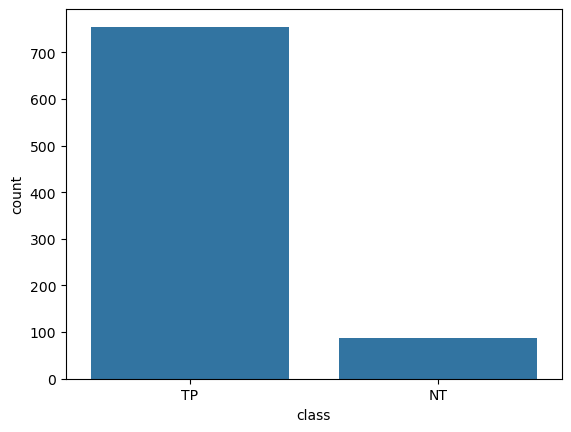

In [35]:
# Gráfico de rótulos
ax = sns.countplot(x="class", data=df)

In [36]:
# Contagem de valores a partir das classes.
df['class'].value_counts()

class
TP    755
NT     87
Name: count, dtype: int64

In [37]:
# Contagem de valores a partir das classes em forma percentual.
df['class'].value_counts(normalize=True)

class
TP    0.896675
NT    0.103325
Name: proportion, dtype: float64

In [38]:
# Análise descritiva com medidas estatísticas.
df.describe() # descreve as medidas estatísticas.

,hsa.let.7a.1,hsa.let.7a.2,hsa.let.7a.3,hsa.let.7b,hsa.let.7c,hsa.let.7d,hsa.let.7e,hsa.let.7f.1,hsa.let.7f.2,hsa.let.7g,...,hsa.mir.940,hsa.mir.941.1,hsa.mir.942,hsa.mir.943,hsa.mir.944,hsa.mir.95,hsa.mir.96,hsa.mir.98,hsa.mir.99a,hsa.mir.99b
count,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,...,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000
mean,9218.938921,18432.504585,9289.250466,26606.604836,3152.699471,558.321269,1289.570177,24.359962,8687.461926,610.223836,...,5.902975,0.003737,6.446279,0.061018,2.320737,3.150482,38.307053,63.746405,1034.572148,44369.112203
std,4843.796136,9704.187427,4858.691217,16745.347957,3238.003201,346.883205,763.056055,12.490091,6052.615278,317.854963,...,8.325681,0.049274,9.541682,0.172214,6.527536,4.287594,33.791795,40.145314,1117.491608,32754.290751
min,1294.149164,2599.981125,1319.952907,1817.920354,148.795934,79.783216,161.181457,2.439034,653.474578,88.614573,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.374223,18.400719,3475.079227
25%,5902.143848,11741.467528,5933.706564,14580.357100,1276.700850,330.638301,809.867504,16.441786,4648.822942,410.859815,...,1.378098,0.000000,2.464140,0.000000,0.373238,1.201951,14.906921,39.913493,387.430475,22769.094433
50%,8016.628565,16040.589880,8103.783439,23097.825936,2352.902327,481.342371,1101.403395,21.890340,7019.157941,532.277053,...,3.192098,0.000000,4.127957,0.000000,1.036215,2.235731,29.634884,52.993693,710.026124,35594.670263
75%,11236.887034,22538.594950,11289.595988,34373.185504,3971.192192,681.931022,1619.864372,29.395515,10926.448322,724.277709,...,7.159431,0.000000,7.551755,0.000000,2.345941,4.030888,51.258145,75.993914,1242.434228,53462.034662
max,45101.697434,90233.655610,45095.490102,144706.427973,59677.212349,3370.036117,11617.011618,121.408006,80780.055188,3342.745045,...,91.996543,0.909391,184.185656,1.757516,122.685820,93.402785,259.127121,399.078716,15689.499524,248074.178531


Esse gráfico e as análises posteriores demonstram um claro desbalanceio em relação aos dados, o que tornará a predição um pouco imprecisa e tendenciosa, por que, como é possível ver, temos muitos dados de TP e poucos dados de NP.Isso pode fazer com que o modelo diagnostique pessoas saudáveis com câncer.

Para que os dados do dataset sejam distribuidos de forma balanceada, irei estabelecer um baseline comparativo.

## Estabelecendo um Baseline Comparativo

Antes de qualque modelagem vamos estabelecer um baseline, i.e., uma solução simples para o problema.

In [39]:
# Definindo os dados de treino e teste (features).
x = df.drop('class', axis=1) # contém todas as colunas do df exceto a coluna 'class'
y = df['class'] # contém as classes preditoras.

# Estabelecendo os parâmetros de teste e treino do dataset para o modelo de previsão.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, stratify=y, random_state=42)

In [40]:
# Contagem de valores a partir das classes TP e NT do y_train
y_train.value_counts(normalize=True)


class
TP    0.896435
NT    0.103565
Name: proportion, dtype: float64

In [41]:
# Contagem de valores a partir das classes TP e NT do y_test
y_test.value_counts(normalize=True) # mostra a proporção de valores em percentual.

class
TP    0.897233
NT    0.102767
Name: proportion, dtype: float64

## Criação de Pipeline

Criarei uma pipeline, que serve para definir o que o algoritmo deve processar para a classificação. Para isso farei uso de uma regressão logística.

In [42]:
lrc = LogisticRegression(random_state=42)

cv_list_lr_baseline = cross_val_score(
    lrc,
    x_train,
    y_train,
    cv=10,
    scoring="balanced_accuracy"
)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [43]:
# Média das pontuações obtidas na validação cruzada
mean_cv_lr_baseline = np.mean(cv_list_lr_baseline)
# Desvio padrão das pontuações obtidas na validação cruzada
std_cv_lr_baseline = np.std(cv_list_lr_baseline)

print(f"Performance (bac): {round(mean_cv_lr_baseline, 4)} +- {round(std_cv_lr_baseline, 4)}")

Performance (bac): 0.9201 +- 0.046


## Modelagem

In [44]:
# Modelagem com KNN
knn = Pipeline(
    [
        ('mms', MinMaxScaler()),
        ('skb', SelectKBest(chi2, k=10)),
        ('knn', KNeighborsClassifier(
            n_neighbors=3,
            p=2,
            weights="uniform"
        ))
    ]
    )

cv_list_knn_euclid = cross_val_score(
    knn,
    x_train,
    y_train,
    cv=10,
    scoring="balanced_accuracy"
)

mean_cv_knn_euclid = np.mean(cv_list_knn_euclid)
std_cv_knn_euclid = np.std(cv_list_knn_euclid)

print(f"Performance (bac): {round(mean_cv_knn_euclid, 4)} +- {round(std_cv_knn_euclid, 4)}")

Performance (bac): 0.9703 +- 0.0377


### Explicação
#### 1. `knn`:
- `Pipeline`: Cria um pipeline de processamento, que é uma sequência de transformações e um estimador final;

- `('mms', MinMaxScaler())`: Adiciona um escalador MinMax, que normaliza os dados para que todos os valores fiquem entre 0 e 1;

- `('skb', SelectKBest(chi2, k=10))`: Seleciona as 10 melhores features com base no teste qui-quadrado (chi2);

- `('knn', KNeighborsClassifier(n_neighbors=3, p=2, weights="uniform"))`: Adiciona o classificador K-Nearest Neighbors (KNN) com 3 vizinhos, usando a distância Euclidiana (p=2) e pesos uniformes;

#### 2. `cv_list_knn_baseline`:
- `cross_val_score`: Realiza cross-validation com 10 dobras (cv=10) para avaliar o desempenho do pipeline `knn` nos dados de treino (`x_train` e `y_train`);

- `scoring="balanced_accuracy"`: Usa a métrica de acurácia balanceada para avaliar o desempenho, que é útil para os dados desbalanceados.

#### 3. `mean_cv_knn_euclid`e `std_cv_knn_euclid`: 
- `np.mean`: Calcula a média das pontuações de cross-validation;

- `np.std`: Calcula o desvio padrão das pontuações de cross-validation;


Ao invés da distância euclidiana, eu vou testar a **distância de Manhattan**. A distância de Manhattan determina a distância entre dois pontos medindo a soma das diferenças absolutas entre as coordenadas dos pontos, ou seja, como se fosse uma grade.

In [45]:
# Manhattan
knn = Pipeline(
    [
        ('mms', MinMaxScaler()),
        ('skb', SelectKBest(chi2, k=10)),
        ('knn', KNeighborsClassifier(
            n_neighbors=3,
            p=1,
            weights="uniform"
        ))
    ]
    )

cv_list_knn_man = cross_val_score(
    knn,
    x_train,
    y_train,
    cv=10,
    scoring="balanced_accuracy"
)

mean_cv_knn_man = np.mean(cv_list_knn_man)
std_cv_knn_man = np.std(cv_list_knn_man)

print(f"Performance (bac): {round(mean_cv_knn_man, 4)} +- {round(std_cv_knn_man, 4)}")

Performance (bac): 0.9638 +- 0.0407


Como o resultado não foi satisfatório, irei testar novamente a Regressão Logística.

In [46]:
# Regressão Logística (l2)
lr = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(
            penalty="l2", # penalidade, usado para evitar overfitting
            C=1, # força de regularização do modelo. Valores pequenos implicam em regularização mais forte
            fit_intercept=True, # bias ou intercepto do modelo
            class_weight="balanced", # peso das classes. Útil para ds desbalanceados
            random_state=42
        )
        )
    ]
)

cv_list_lr_l2 = cross_val_score(
    lr,
    x_train,
    y_train,
    cv=10,
    scoring="balanced_accuracy"
)

mean_cv_lr_l2 = np.mean(cv_list_lr_l2)
std_cv_lr_l2 = np.std(cv_list_lr_l2)

print(f"Performance (bac): {round(mean_cv_lr_l2, 4)} +- {round(std_cv_lr_l2, 4)}")

Performance (bac): 0.9655 +- 0.0391


In [47]:
# Regressão Logística (l1)
lr = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(
            penalty="l1", # penalidade, usado para evitar overfitting
            C=1, # força de regularização do modelo. Valores pequenos implicam em regularização mais forte
            fit_intercept=True, # bias ou intercepto do modelo
            solver = "liblinear",
            class_weight="balanced", # peso das classes. Útil para ds desbalanceados
            random_state=42
        )
        )
    ]
)

cv_list_lr_l1 = cross_val_score(
    lr,
    x_train,
    y_train,
    cv=10,
    scoring="balanced_accuracy"
)

mean_cv_lr_l1 = np.mean(cv_list_lr_l1)
std_cv_lr_l1 = np.std(cv_list_lr_l1)

print(f"Performance (bac): {round(mean_cv_lr_l1, 4)} +- {round(std_cv_lr_l1, 4)}")

Performance (bac): 0.9665 +- 0.0373


- `('scaler', StandardScaler())`: Adiciona um escalonador padrão, que normaliza os dados para que tenham média 0 e desvio padrão 1.

- `('lr', LogisticRegression())`: Adiciona o modelo de Regressão Logística com os seguintes parâmetros:

- `penalty="l2"`: Aplica uma penalidade L2 (regularização de Ridge) para evitar overfitting.

- `C=1`: Define a força de regularização. Valores menores implicam em regularização mais forte.

- `fit_intercept=True`: Inclui um intercepto (bias) no modelo.

- `class_weight="balanced"`: Ajusta os pesos das classes inversamente proporcionais às suas frequências, útil para conjuntos de dados desbalanceados.

- `random_state=42`: Define uma semente para a geração de números aleatórios, garantindo reprodutibilidade.
- `solver="liblinear"`: Indica que o algoritmo de otimização é o `liblinear`, que é adequado para pequenos conjuntos de dados. Suporta l1 e l2.

## PCA (Principal Component Analysis): 
Reduz a dimensionalidade de um conjunto de dados de forma que preserve os dados. Serve para melhorar a acurácia de um modelo.

In [48]:
lr = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=10)),
        ('lr', LogisticRegression(
            penalty="l2", # penalidade, usado para evitar overfitting
            C=1, # força de regularização do modelo. Valores pequenos implicam em regularização mais forte
            fit_intercept=True, # bias ou intercepto do modelo
            class_weight="balanced", # peso das classes. Útil para ds desbalanceados
            random_state=42
        )
        )
    ]
)

cv_list_lr_pca = cross_val_score(
    lr,
    x_train,
    y_train,
    cv=10,
    scoring="balanced_accuracy"
)

mean_cv_lr_pca = np.mean(cv_list_lr_pca)
std_cv_lr_pca = np.std(cv_list_lr_pca)

print(f"Mean CV: {mean_cv_lr_pca:.3f} | Std CV: {std_cv_lr_pca:.3f}")

Mean CV: 0.982 | Std CV: 0.023


Agora, obtivemos uma acurácia de 98.2%, o que é uma melhoria significativa em relação ao modelo anterior.

## Avaliação Experimental

In [49]:
# resultados da cross-validation
df_result_cv = pd.DataFrame(
    [cv_list_lr_baseline, cv_list_knn_euclid, cv_list_knn_man, cv_list_lr_l2, cv_list_lr_l1 ,cv_list_lr_pca],
    index=["LR Baseline", "KNN Euclid", "KNN Man", "LR L2", "LR L1", "LR PCA"]
).T

df_result_cv


,LR Baseline,KNN Euclid,KNN Man,LR L2,LR L1,LR PCA
0,0.907233,1.000000,0.916667,0.990566,0.990566,0.990566
1,0.990566,0.981132,0.990566,0.888365,0.981132,0.981132
2,0.971698,0.990566,0.990566,0.990566,0.990566,0.990566
3,0.907233,0.916667,0.916667,0.916667,0.907233,0.990566
4,0.907233,1.000000,1.000000,0.990566,1.000000,1.000000
5,0.916667,0.916667,0.916667,0.916667,0.916667,0.916667
6,0.907233,0.907233,0.907233,0.981132,0.907233,0.990566
7,0.878931,0.990566,1.000000,0.990566,0.981132,0.981132
8,0.980769,1.000000,1.000000,0.990385,0.990385,0.980769
9,0.833333,1.000000,1.000000,1.000000,1.000000,1.000000


In [50]:
# 
df_res = df_result_cv.stack().to_frame("balanced_accuracy")
df_res.index.rename(["fold", "pipelines"], inplace=True)
df_res.reset_index()
df_res.head(12)

balanced_accuracy
fold pipelines                     
0    LR Baseline           0.907233
     KNN Euclid            1.000000
     KNN Man               0.916667
     LR L2                 0.990566
     LR L1                 0.990566
     LR PCA                0.990566
1    LR Baseline           0.990566
     KNN Euclid            0.981132
     KNN Man               0.990566
     LR L2                 0.888365
     LR L1                 0.981132
     LR PCA                0.981132

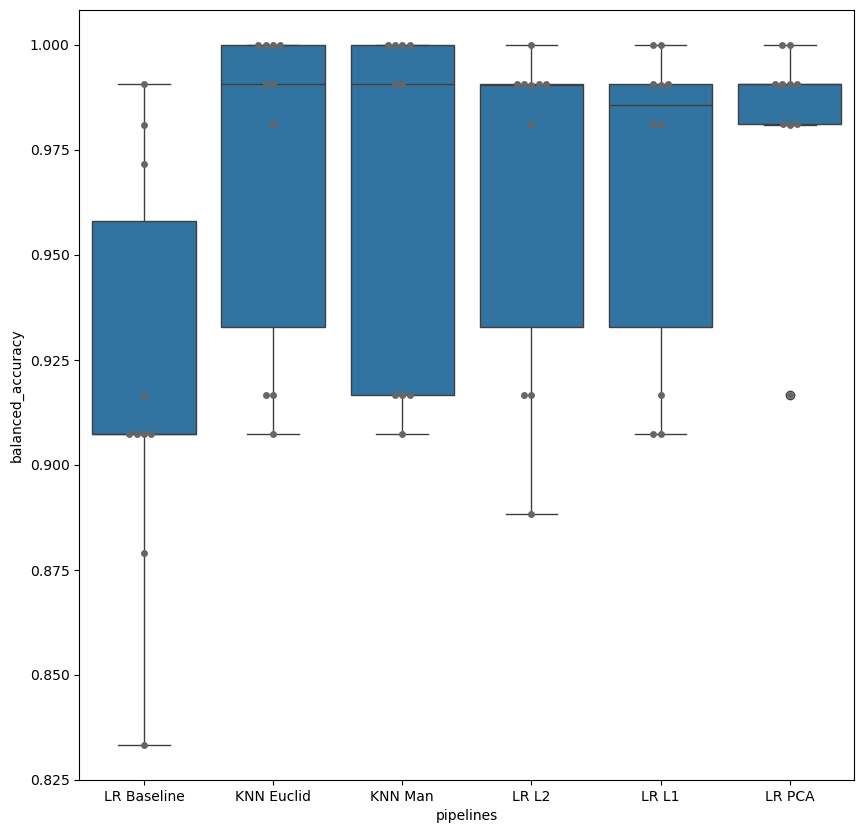

In [51]:
#
plt.figure(figsize=(10,10))

ax = sns.boxplot(x="pipelines", y="balanced_accuracy", data=df_res)
ax = sns.swarmplot(x="pipelines", y="balanced_accuracy", data=df_res, color=".40")

<Figure size 1000x1000 with 0 Axes>

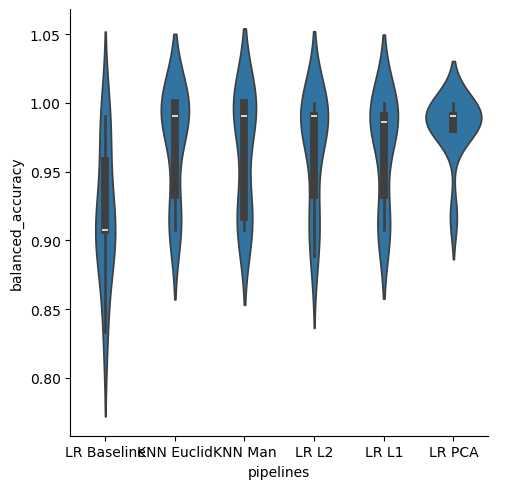

In [52]:
#
plt.figure(figsize=(10,10))

sns.catplot(x="pipelines", y="balanced_accuracy", kind="violin", data=df_res)

## Avaliação Final de Performance do Modelo

In [53]:
# retreinar o pipeline selecionado com todos os dados de treinamento.
lr = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=10)),
        ('lr', LogisticRegression(
            penalty="l2", # penalidade, usado para evitar overfitting
            C=1, # força de regularização do modelo. Valores pequenos implicam em regularização mais forte
            fit_intercept=True, # bias ou intercepto do modelo
            class_weight="balanced", # peso das classes. Útil para ds desbalanceados
            random_state=42
        )
        )
    ]
)

lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
lr_pca_test = balanced_accuracy_score(y_test, y_pred)

print(f"Performance: {round(lr_pca_test, 4) * 100}%")

Performance: 97.2%


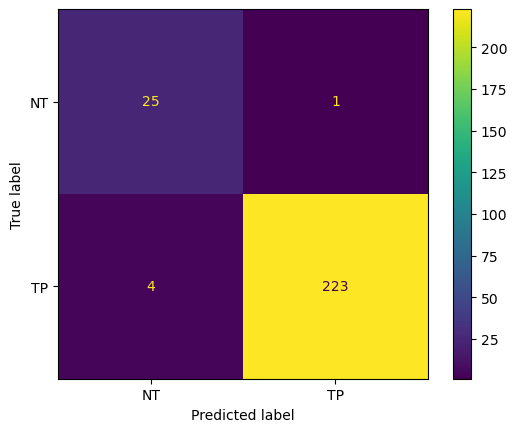

In [ ]:
# Confusion Matrix de Dados de Treino

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(lr, x_test, y_test)
plt.show()


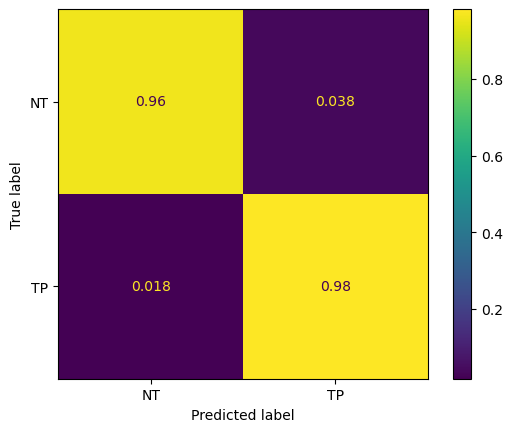

In [58]:
# Confusion Matrix de Dados de Testes em Percentual
ConfusionMatrixDisplay.from_estimator(lr, x_test, y_test, normalize="true")
plt.show()

## Referências & Links



1. [The Cancer Genome Atlas Program](https://www.cancer.gov/about-nci/organization/ccg/research/structural-genomics/tcga)
2. [Micro RNA](https://en.wikipedia.org/wiki/MicroRNA_sequencing)
3. [Sklearn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
